In [1]:
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from sklearn.metrics import auc

#### Dataset Link: [Object Detection Metrics](https://github.com/rafaelpadilla/Object-Detection-Metrics/tree/master/samples/sample_2)

In [2]:
gt_path = 'object_detection_dataset/groundtruths/'
det_path = 'object_detection_dataset/detections/'
num_images = 7
iou_threshold = 0.3
classes = ['object']

In [3]:
def get_gt_bboxes(gt_file_path):
    with open(gt_file_path) as f:
        data = f.read().splitlines()

    data = list(map(lambda x: x.strip().split(' '), data))
    df = pd.DataFrame(data, columns=['class', 'x1', 'y1', 'w', 'h'])
    df[['x1', 'y1', 'w', 'h']] = df[['x1', 'y1', 'w', 'h']].astype('int')
    return df

def get_det_bboxes(det_file_path):
    with open(det_file_path) as f:
        data = f.read().splitlines()

    data = list(map(lambda x: x.strip().split(' '), data))
    df = pd.DataFrame(data, columns=['class', 'conf', 'x1', 'y1', 'w', 'h'])
    df[['x1', 'y1', 'w', 'h', 'conf']] = df[['x1', 'y1', 'w', 'h', 'conf']].astype('float')
    df.sort_values(by=['class', 'conf'], ascending=False, inplace=True)
    return df    

In [4]:
def get_poly(bbox):
    x1, y1, w, h = bbox.ravel()
    poly = Polygon([[x1, y1], [x1, y1+h], [x1+w, y1+h], [x1+w, y1]])
    return poly

def get_iou(gt, det):
    poly_det = get_poly(det)
    poly_gt = get_poly(gt)
    iou = poly_det.intersection(poly_gt).area / poly_det.union(poly_gt).area
    return iou

In [5]:
def get_outcomes(gts, dets):
    gt_flag = np.zeros(len(gts))
    det_outcomes = np.array([None] * len(dets))

    for det_idx, det in enumerate(dets):
        max_iou = -float('inf')
        max_iou_idx = None
        
        for gt_idx, gt in enumerate(gts):
            iou = get_iou(gt, det)

            if iou > max_iou:
                max_iou = iou
                max_iou_idx = gt_idx

        if max_iou >= iou_threshold:
            if gt_flag[max_iou_idx] == 0:
                det_outcomes[det_idx] = 'TP'
                gt_flag[max_iou_idx] = 1
            else:
                det_outcomes[det_idx] = 'FP'
        else:
            det_outcomes[det_idx] = 'FP'
    return det_outcomes

In [6]:
total_act_pos = {object_class:0 for object_class in classes}

for idx in range(1, num_images+1):
    gt_file_path = gt_path + str(idx).zfill(5) + '.txt'
    det_file_path = det_path + str(idx).zfill(5) + '.txt'

    df_gt = get_gt_bboxes(gt_file_path)
    df_det = get_det_bboxes(det_file_path)
    df_det['image_idx'] = idx
    df_det['outcomes'] = None 
    
    for object_class in classes:
        gts = df_gt[df_gt['class'] == object_class][['x1', 'y1', 'w', 'h']].values
        dets = df_det[df_det['class'] == object_class][['x1', 'y1', 'w', 'h']].values
    
        det_outcomes = get_outcomes(gts, dets)
        df_det.loc[df_det['class'] == object_class, 'outcomes'] = det_outcomes
        total_act_pos[object_class] += len(gts)

    if idx==1:
        df_dets = df_det.copy()
    else:
        df_dets = pd.concat([df_dets, df_det])

In [7]:
def get_metrics(df_dets, num_pos):
    df_dets.sort_values(by='conf', ascending=False, inplace=True)
    df_dets = df_dets[['image_idx', 'class', 'conf', 'x1', 'y1', 'w', 'h', 'outcomes']].reset_index(drop=True)
    df_dets = pd.concat([df_dets, pd.get_dummies(df_dets['outcomes'])], axis=1)
    df_dets.drop('outcomes', axis=1, inplace=True)

    df_dets['cumsum_FP'] = np.cumsum(df_dets['FP'])
    df_dets['cumsum_TP'] = np.cumsum(df_dets['TP'])
    df_dets['prec'] = df_dets['cumsum_TP'] / (df_dets['cumsum_TP'] + df_dets['cumsum_FP'])
    df_dets['rec'] = df_dets['cumsum_TP'] / num_pos
    return df_dets

def get_interpolated_precs(precs, recs, itp_recs):
    itp_precs = []
    for itp_rec in itp_recs:
        idxs = np.where(recs>=itp_rec)[0]
        if len(idxs):
            itp_prec = np.max(precs[idxs])
        else:
            itp_prec = 0
        itp_precs.append(itp_prec)
    return itp_precs    

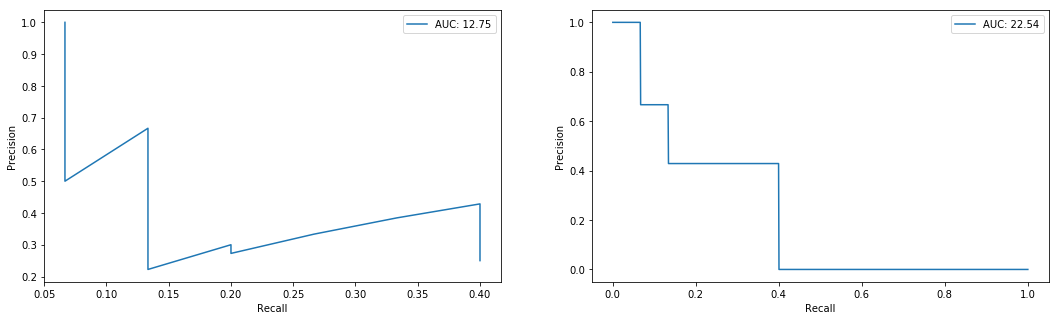

In [8]:
num_pos = total_act_pos['object']
df_dets = get_metrics(df_dets, num_pos)
plt.figure(figsize=(18,5))
plt.subplot(121)
precs = df_dets['prec'].values
recs = df_dets['rec'].values
auc_score = auc(recs, precs).round(4) * 100
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recs, precs, label=f'AUC: {auc_score}')
plt.legend()

plt.subplot(122)
itp_recs = np.linspace(0,1,1000)
itp_precs = get_interpolated_precs(precs, recs, itp_recs)
auc_score = auc(itp_recs, itp_precs).round(4) * 100
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(itp_recs, itp_precs, label=f'AUC: {auc_score}')
plt.legend()
plt.show()

In [9]:
df_dets

,image_idx,class,conf,x1,y1,w,h,FP,TP,cumsum_FP,cumsum_TP,prec,rec
0,5,object,0.95,29.0,131.0,72.0,29.0,0,1,0,1,1.000000,0.066667
1,7,object,0.95,33.0,116.0,37.0,49.0,1,0,1,1,0.500000,0.066667
2,3,object,0.91,105.0,131.0,47.0,47.0,0,1,1,2,0.666667,0.133333
3,1,object,0.88,5.0,67.0,31.0,48.0,1,0,2,2,0.500000,0.133333
4,6,object,0.84,17.0,155.0,29.0,35.0,1,0,3,2,0.400000,0.133333
5,1,object,0.80,124.0,9.0,49.0,67.0,1,0,4,2,0.333333,0.133333
6,4,object,0.78,28.0,68.0,42.0,67.0,1,0,5,2,0.285714,0.133333
7,2,object,0.74,19.0,18.0,43.0,35.0,1,0,6,2,0.250000,0.133333
8,2,object,0.71,64.0,111.0,64.0,58.0,1,0,7,2,0.222222,0.133333
9,1,object,0.70,119.0,111.0,40.0,67.0,0,1,7,3,0.300000,0.200000


In [10]:
total_TP = np.sum(df_dets['TP'])
total_FP = np.sum(df_dets['FP'])

overall_prec = total_TP / (total_TP + total_FP)
overall_rec = total_TP / num_pos
overall_prec, overall_rec

(0.25, 0.4)